# Analyse des données textuelles des titres d'articles parus sur le site LegiFrance

Cette analyse a été réalisée dans le cadre de l'événement de la Nuit du Code Citoyen à Paris les 15-17 octobre 2021. 

Seul l'ajout de commentaire et de textes a été réalisé a posteriori de l'événement pour permettre à d'autres personnes de comprendre la démarche. 

- Configuration

In [1]:
# depandancies installation
!pip install pyLDAvis
!pip install --upgrade pyLDAvis
!pip install spacy
!pip install --upgrade spacy
!pip install nltk
!pip install tomotopy
!pip install --upgrade scikit-learn
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 17.1 MB 167 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [2]:
# stopwords download
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [4]:
sns.set_palette("Set2")

In [5]:
# connexion à Google Drive pour importer les dossiers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = "/content/drive/My Drive/NCC - 2021/titles_large.csv"

# Importation du fichier et analyses des données

In [7]:
data = pd.read_csv(path, encoding="utf-8")
print(data.head())

                     id  ...                                              titre
0  JORFTEXT000044212582  ...  Décret n° 2021-1346 du 15 octobre 2021 relatif...
1  JORFTEXT000044212593  ...  Arrêté du 25 mai 2021 modifiant l'arrêté du 4 ...
2  JORFTEXT000044212600  ...  Arrêté du 12 juillet 2021 portant suppression ...
3  JORFTEXT000044212608  ...  Arrêté du 12 juillet 2021 modifiant l'arrêté d...
4  JORFTEXT000044212615  ...  Décision du 12 octobre 2021 modifiant la décis...

[5 rows x 4 columns]


In [8]:
data["nature"] = data["nature"].str.capitalize()
data["emetteur"] = data["emetteur"].str.capitalize()

In [9]:
data.drop_duplicates("id", inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134953 entries, 0 to 134952
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        134953 non-null  object
 1   emetteur  127794 non-null  object
 2   nature    134682 non-null  object
 3   titre     134953 non-null  object
dtypes: object(4)
memory usage: 5.1+ MB


On dispose d'un jeu de données composé de 4 colonnes contenant les identifiants de parution au journal officiel, l'émetteur, la nature du texte et son titre. Le nombre d'articles est de 134 953. Un premier nettoyage a été effectué pour enlever les doublons sur les identifiants. On remarque que 7 158 articles n'ont pas d'émetteurs renseignés et 271 articles n'ont pas de nature identifiés. 

## Analyse descriptive des données qualitatives

- Emetteurs des textes

In [12]:
print('Nombre d\'émetteurs :', data["emetteur"].nunique())

Nombre d'émetteurs : 155


In [11]:
print("Noms des émetteurs :", data["emetteur"].unique())

Noms des émetteurs : ['Ministère de la transition écologique'
 "Ministère de l'éducation nationale, de la jeunesse et des sports"
 "Ministère de l'économie, des finances et de la relance"
 "Ministère de l'intérieur"
 'Ministère de la cohésion des territoires et des relations avec les collectivités territoriales'
 'Ministère de la justice' 'Ministère de la mer'
 "Ministère de l'agriculture et de l'alimentation"
 'Ministère de la transition écologique transports'
 "Ministère de l'éducation nationale, de la jeunesse et des sports sports"
 "Ministère de l'économie, des finances et de la relance comptes publics"
 "Ministère du travail, de l'emploi et de l'insertion"
 'Conseil constitutionnel' 'Cour de justice de la république'
 'Autorité de la concurrence' 'Autorité de contrôle prudentiel'
 "Conseil supérieur de l'audiovisuel"
 'Conseil économique, social et environnemental' 'Premier ministre'
 "Ministère de l'europe et des affaires étrangères" 'Ministère des armées'
 'Ministère de la cultu

On dénombre 155 instituts émettrices sur la période entre 2013 et 2021. La liste des émetteurs montrent qu'il existe des modifications de noms entre ministères (ministère de la santé, ministère des solidarités et de la santé, minitère des affaires sociales et de la santé).

Il pourrait être intéressant d'harmoniser ces noms pour permettre un meilleur référencement. La création de sous-catégorie en lien avec les ministères peut être une solution d'organiser et prendre en compte les cabinets des secrétaires d'Etat.

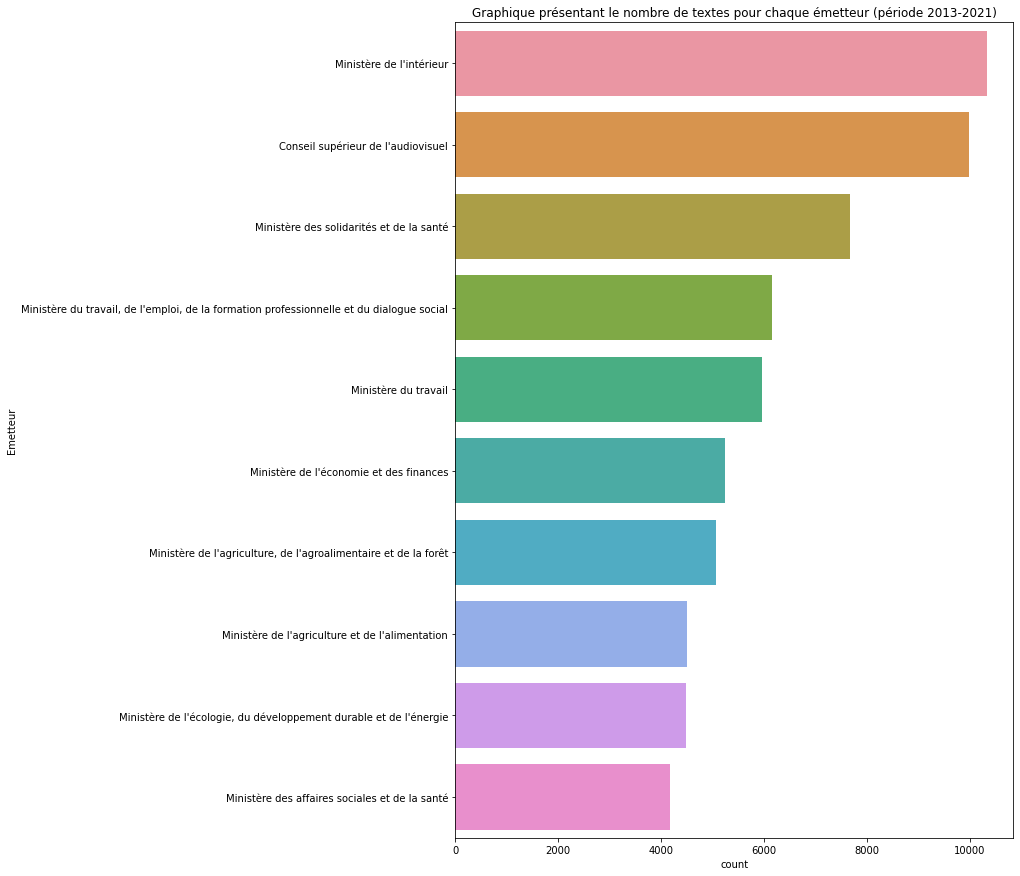

In [13]:
plt.figure(figsize=(10, 15))
sns.countplot(y="emetteur",
              data=data,
              order=data["emetteur"].value_counts().index[:10])
plt.ylabel("Emetteur")
plt.title("Graphique présentant le nombre de textes pour chaque émetteur (période 2013-2021)")
plt.show()

Sur la période disponible (entre 2013 et 2021), on remarque que le ministère de l'intérieur est le plus grand émetteur de textes de loi suivi par le conseil de surveillance de l'audiovisuel et du ministère des solidarités et de la santé.

- Nature des textes

In [14]:
print('Nature des textes :', data["nature"].nunique())

Nature des textes : 31


In [15]:
# add accentued chars
data["nature"] = data["nature"].replace({"Arrete" : "Arrêté",
                                         "Decision" : "Décision",
                                         "Decret" : "Décret",
                                         "Deliberation" : "Délibération"}, regex=True)

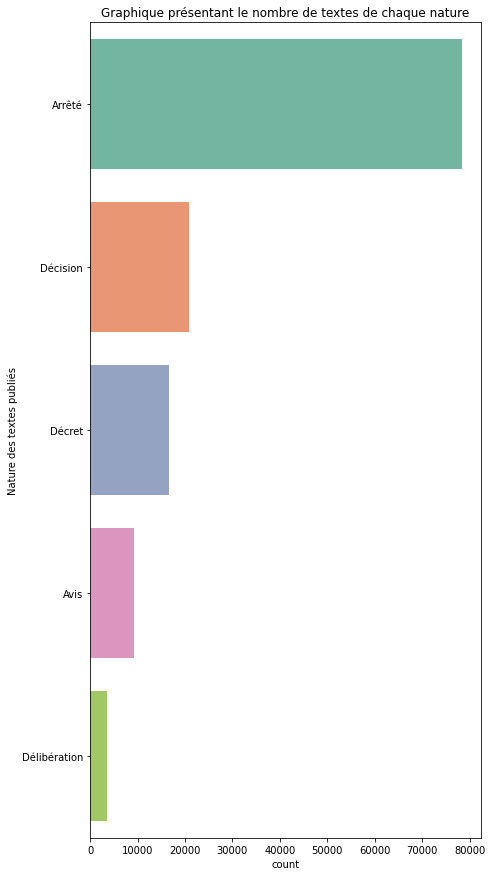

In [16]:
plt.figure(figsize=(7, 15))
sns.countplot(y="nature",
              data=data,
              order=data["nature"].value_counts().index[:5])
plt.title("Graphique présentant le nombre de textes de chaque nature")
plt.ylabel("Nature des textes publiés")
plt.show()

Les textes de type "Arrêté" sont les plus fréquents. Ils sont suivis par les décisions et les décrets. 

## Conclusion

Cette partie nous a permis d'avoir une vue d'ensemble des données obtenues sur le site LégiFrance. On remarque qu'il existe une grande diversité d'émetteurs et qu'il pourrait être **judicieux de les organiser de manière à éviter les "doublons"**.

# Nettoyage des données textuelles

Dans cette partie, on va s'intéresser uniquement aux contenus des titres des différents textes à notre disposition.

In [17]:
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
import spacy
print(stopwords.words("french"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by its

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [18]:
nlp = spacy.load('fr_core_news_sm')
tokenizer = ToktokTokenizer()

In [19]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def tok(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text)

def normalize_corpus(corpus, accented_char_removal=True,
                     text_lower_case=True, text_lemmatization=True,
                     special_char_removal=True, stopword_removal=True,
                     remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [20]:
stop_words = set(stopwords.words('french'))
stop_words.add("janvier")
stop_words.add("fevrier")
stop_words.add("mars")
stop_words.add("avril")
stop_words.add("mai")
stop_words.add("juin")
stop_words.add("juillet")
stop_words.add("aout")
stop_words.add("septembre")
stop_words.add("octobre")
stop_words.add("novembre")
stop_words.add("decembre")
stop_words.add("arrete")
stop_words.add("loi")
stop_words.add("decret")
stop_words.add("decision")
stop_words.add("arret")
stop_words.add("er")
stop_words.add("deliberation")
stop_words.add("length")
stop_words.add("dtype")
stop_words.add("Name")
stop_words.add("avis")
stop_words.add("relatif")
stop_words.add("modifier")
stop_words.add("porter")
stop_words.add("designation")
stop_words.add("suppression")
stop_words.add("modalite")
stop_words.add("fixer")
stop_words.add("autoriser")
stop_words.add("conclus")
stop_words.add("conclusion")
stop_words.add("conclure")
stop_words.add("entre")
stop_words.add("convenant")
stop_words.add("delegation")
stop_words.add("avoir")
stop_words.add("direction")
stop_words.add("general")
stop_words.add("renomme")
stop_words.add("annee")
stop_words.add("mentionne")
stop_words.add("code")
stop_words.add("article")
stop_words.add("paragraphe")
stop_words.add("alinea")

La liste des stopwords (mots n'apportant pas plus d'informations) a été élargie pour pouvoir affiner la recherche de thématiques dans notre corpus de documents. Cette extension a été réalisé suite à des observations du jeu de données. **L'avis d'un expert-métier pourrait apporter une plus-value pour construire un vocabulaire propre à l'analyse de textes de loi.**

In [21]:
data["titre"] = normalize_corpus(data['titre'])

In [22]:
data['titre'] = data['titre'].replace({"acce" : "acces"},
                      regex=True)
data['titre'] = data['titre'].replace({"definisser" : "definir"},
                      regex=True)
data['titre'] = data['titre'].replace({"avener" : "avenant"},
                      regex=True)
data['titre'] = data['titre'].replace({"naturer" : "nature"},
                      regex=True)

In [23]:
print(data.head())

                     id  ...                                              titre
0  JORFTEXT000044212582  ...  date transfert definitif service party service...
1  JORFTEXT000044212593  ...  site nature affluent rive droite rhone zone sp...
2  JORFTEXT000044212600  ...  site nature vallee loire allier zone special c...
3  JORFTEXT000044212608  ...  site nature vallee loire fourchambault neuvysu...
4  JORFTEXT000044212615  ...                           signature energie climat

[5 rows x 4 columns]


### Conclusion

Le nettoyage de cette partie gagnerait à être améliorer en ayant l'avis de personnes utilisant l'outil LégiFrance pour effectuer une veille. Actuellement, la liste de stopwords reste à améliorer pour prendre en compte ce que des experts du domaine considéreraient comme du bruit. 

## Distribution des mots les plus fréquents dans les titres

In [24]:
from wordcloud import WordCloud

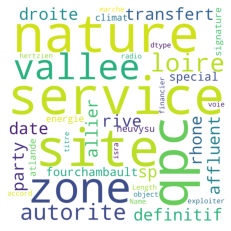

In [25]:
wc = WordCloud(background_color="white",
               width=2000,
               height=2000,
               max_words=10000)
wc.generate(str(data["titre"]))
plt.axis("off")
plt.imshow(wc);

La représentation visuelle des mots contenus dans les titres montrent une grande prépondérance de mots comme "service", "nature", "vallée", "site", etc. laissant imaginer que beaucoup de textes sont en lien avec l'environnement. 

In [26]:
#data.to_csv("title_large_preprocess.csv", index=False)

# Modélisation : topic modeling

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
vectorizer = CountVectorizer(max_features=1000)

In [29]:
data_vec = vectorizer.fit_transform(data['titre'])

In [30]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                random_state=42,
                                batch_size=400,
                                n_jobs=-1)

In [31]:
lda.fit(data_vec)

LatentDirichletAllocation(batch_size=400, n_jobs=-1, random_state=42)

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, data_vec, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  12.183761
6       0.648955  71.707100       2        1  11.580044
9      71.019684   9.971006       3        1  11.546953
3       3.785981  33.185135       4        1  10.827435
7     -42.666500  -9.222070       5        1  10.797359
8      -3.621689 -43.526516       6        1  10.046647
0      -3.632402  -4.171708       7        1   9.417522
2     -36.584400  35.804413       8        1   8.615210
1      44.391380  50.615383       9        1   7.615369
4      40.235809 -31.591665      10        1   7.369700, topic_info=           Term          Freq         Total Category  logprob  loglift
228  convention  14451.000000  14451.000000  Default  30.0000  30.0000
775       radio  12722.000000  12722.000000  Default  29.0000  29.0000
383   extension  14628.000000  14628.000000  Default  28.0000  28.0000
172   collectif  14029.000000  14029.000000  Default  27.0000  27.0000
8        accord  10512.000000  10512.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
239    creation   1501.373636   6575.487566  Topic10  -4.0636   1.1308
825      reseau   1110.480498   2747.768552  Topic10  -4.3652   1.7018
3         acces   1251.680009   6297.753836  Topic10  -4.2455   0.9921
423      france    989.701868   6382.752380  Topic10  -4.4804   0.7438
226    controle    937.449896   3072.196986  Topic10  -4.5346   1.4208

[580 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         5  0.998350  academie
3         1  0.693739     acces
3         2  0.000794     acces
3         5  0.106546     acces
3        10  0.198801     acces
...     ...       ...       ...
995      10  0.999163       vol
998      10  0.998715       zit
999       6  0.024805      zone
999       8  0.666499      zone
999      10  0.308444      zone

[1148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 10, 4, 8, 9, 1, 3, 2, 5])

Le nombre de topics a été fixé de manière arbitraire. Cela nous a permis de tester la pertinence de la réalisation d'un algorithme de Latent Dirichlet Allocation pour dégager des thématiques dans nos titres. Suite à la sortie des 30 mots les plus fréquents, on peut déduire les thématiques suivantes :
- **Thématique 1** : Concours et examens
- **Thématique 2** : Formation professionnel
- **Thématique 3** : Législation du travail
- **Thématique 4** : Santé et action sociale
- **Thématique 5** : Enseignement et recherche
- **Thématique 6** : Radio
- **Thématique 7** : Banque et finance
- **Thématique 8** : Télévision
- **Thématique 9** : Agriculture
- **Thématique 10** : Energie

Suite à cet essai, on va optimiser les performances de notre algorithme. Cependant les résultats obtenus concerneront une performance optimale d'un point de vue technique mais peut ne pas refléter le besoin métier. En absence d'expertise métier, des valeurs arbitraires de thématiques ont été fixés pour pouvoir aller au bout de cet analyse.

In [33]:
from sklearn.model_selection import GridSearchCV

params = {'n_components' : [10, 11, 12, 13, 14, 15],
          "learning_decay" : [0.5, 0.7, 0.9]}

gridsearch = GridSearchCV(lda,
                         param_grid = params,
                         cv = 3,
                         verbose=2)
gridsearch.fit(data_vec)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ................learning_decay=0.5, n_components=10; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=10; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=10; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=11; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=11; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=11; total time= 2.3min
[CV] END ................learning_decay=0.5, n_components=12; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=12; total time= 2.5min
[CV] END ................learning_decay=0.5, n_components=12; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=13; total time= 2.4min
[CV] END ................learning_decay=0.5, n_components=13; total time= 2.5min
[CV] END ................learning_decay=0.5, n_c

GridSearchCV(cv=3,
             estimator=LatentDirichletAllocation(batch_size=400, n_jobs=-1,
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 11, 12, 13, 14, 15]},
             verbose=2)

In [34]:
best_model = gridsearch.best_estimator_

print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 15}
Best Log Likelihood Score:  -2217939.9352603354


In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_model, data_vec, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
9      114.344879  114.308296       1        1  9.435793
10     105.821045  -93.749626       2        1  9.094527
8     -138.334473   95.320763       3        1  8.970477
14      -7.436697  111.259697       4        1  8.156552
12    -207.550629 -105.472603       5        1  7.452359
5       52.817650   14.603765       6        1  7.319450
2      168.010849    6.806950       7        1  7.063820
7      -94.169601 -157.789551       8        1  7.031703
1     -122.849174  -39.059418       9        1  6.190659
6      -94.894264  195.408295      10        1  5.465224
13      24.927401 -180.464874      11        1  5.227498
3      -53.413467   26.832108      12        1  4.957796
4      -12.255850  -72.093201      13        1  4.681627
11    -224.217957   28.070581      14        1  4.597892
0       36.154255  209.427582      15        1  4.354622, topic_info=               Term          Freq         Total Category  logprob  loglift
228      convention  14215.000000  14215.000000  Default  30.0000  30.0000
775           radio  12416.000000  12416.000000  Default  29.0000  29.0000
383       extension  14384.000000  14384.000000  Default  28.0000  28.0000
172       collectif  13811.000000  13811.000000  Default  27.0000  27.0000
875       signature   7381.000000   7381.000000  Default  26.0000  26.0000
..              ...           ...           ...      ...      ...      ...
400      financiere    516.902523   1175.629252  Topic15  -4.6038   2.3122
304           droit    596.186561   2803.560455  Topic15  -4.4611   1.5858
23   administration    598.081890   3968.088406  Topic15  -4.4579   1.2416
670          ouvrir    447.080482   1436.952477  Topic15  -4.7489   1.9664
594       ministere    459.429885   5551.662199  Topic15  -4.7216   0.6421

[790 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3         5  0.167167  acces
3         6  0.565458  acces
3         8  0.086945  acces
3        10  0.000156  acces
3        13  0.180302  acces
...     ...       ...    ...
999       3  0.003077   zone
999       5  0.207928   zone
999       7  0.450365   zone
999      11  0.327498   zone
999      14  0.011210   zone

[1924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 11, 9, 15, 13, 6, 3, 8, 2, 7, 14, 4, 5, 12, 1])

L'optimisation de l'algorithme utilisé montre que le nombre idéal de thématiques est de 15. On pourrait les définir de la manière suivante : 
- **Thématique 1** : Législation du travail
- **Thématique 2** : Santé et action sociale
- **Thématique 3** : Radio
- **Thématique 4** : Environnement et territoire
- **Thématique 5** : Concours
- **Thématique 6** : Examen professionnel
- **Thématique 7** : Télévision
- **Thématique 8** : Recherche
- **Thématique 9** : Travail, agriculture et hygiène
- **Thématique 10** : Sport, jeunesse et formation spécifique
- **Thématique 11** : Finance et budget
- **Thématique 12** : Législation sur la santé/Assurance maladie
- **Thématique 13** : Energie
- **Thématique 14** :  ???
- **Thématique 15** : Armée


# Conclusion

L'analyse des données obtenues sur le site LegiFrance a montré qu'il y était possible de faire un travail de classification.
- La présence de ministère avec des noms différents rend la navigation fastidieuse lors de la recherche de textes. Concernant ce point, une réorganisation de la hiérarchie peut être une solution à envisager. 
- Une approche non-supervisé a permis de montrer qu'il était possible de retrouver des thématiques à partir uniquement des titres des articles publiés sur le site LégiFrance. A partir de cette recherche, il est possible d'attacher une thématique ainsi qu'un mot-clé à chaque texte pour améliorer leur référencement ainsi que leur recherche sur le site. 

L'approche utilisée comporte aussi des défauts. L'absence de connaissance dans le domaine a fait que le nombre de thématique a été imposé de manière arbitraire puis selon des contraintes mathématiques de minimisation de la fonction de perte (représentée par le logarithme de la vraisemblance). L'ajout de mots "indésirables" (stopwords) a aussi été fait sur la base d'une observation. Ce point pourrait aussi être améliorer par l'expertise d'une personne utilisant LégiFrance au quotidien. 

### Idées d'amélioration : 
- Tester d'autres algorithmes de topic modeling pour définir des thématiques et des mots-clés (par ex. HLDA, GSDMM)
- Ajouter le texte des articles au titre pour faire une recherche plus complète sur ce point (la partie texte des articles a été réalisé dans un autre notebook)
- Définir des uses cases avec des experts du domaine ayant besoin de LegiFrance
- Harmoniser les labels/mots-clés sur ceux présents sur le site européen (Eur-Lex)
- Automatiser l'attribution des mots-clés
- Intégrer un algorithme de classification automatique sur le site LegiFrance à partir des pistes ci-dessus
- Permettre l'ajout de thématiques manuellement pour rendre l'outil collaboratif


Liens utiles :
- https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883
- https://dl.acm.org/doi/10.1145/2623330.2623715
- https://arxiv.org/pdf/1904.07695.pdf
- https://labelstud.io/ (librairie d'annotation automatique)

*Ce travail a été réalisé par Cécile Guillot (https://github.com/Sylvariane) dans le cadre de la nuit du code citoyen 2021.*